In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [13]:
df = pd.read_csv('downPackets.csv', sep= ";")

In [14]:
df.head()

,id,imme,tmst,tmms,freq,rfch,powe,modu,datr,codr,fdev,ipol,prea,size,data,ncrc
0,1,0,1729162410,Nan,868.3,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,33,IB9CLTWIvANzFRobSHpfDItCRiVKLq7ZBuDwrAXT8Uk+,1
1,2,0,1729162418,Nan,867.9,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAAADUP8AAQYBWQxO,1
2,3,0,1729162436,Nan,868.3,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAQADUf8AAQYnNE+f,1
3,4,0,1729162454,Nan,868.1,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAgADUf8AAQb82c+D,1
4,5,0,1729162472,Nan,868.3,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAwADUf8AAQZbuxCb,1


In [15]:
df.shape

(503, 16)

### Decoding Data Column

In [16]:
import base64
from pprint import pprint

def decode_lorawan_packet(base64_packet):
    try:
        # Decode the base64 packet into bytes
        packet_bytes = base64.b64decode(base64_packet)

        # Initialize an empty dictionary to store packet components
        packet_dict = {}

        # Extracting the MHDR (Message Header)
        packet_dict['MHDR'] = packet_bytes[0]
        packet_dict['MType'] = (packet_bytes[0] >> 5) & 0x07
        packet_dict['RFU'] = (packet_bytes[0] >> 2) & 0x07
        packet_dict['Major'] = packet_bytes[0] & 0x03

        # Extract DevAddr (4 bytes, little-endian)
        devaddr_bytes = packet_bytes[1:5]
        packet_dict['DevAddr'] = devaddr_bytes[::-1].hex()

        # FCtrl (Frame Control)
        packet_dict['FCtrl'] = packet_bytes[5]

        # FCnt (Frame Counter, 2 bytes, little-endian)
        fcnt_bytes = packet_bytes[6:8]
        packet_dict['FCnt'] = int.from_bytes(fcnt_bytes, byteorder='little')

        # Optional FOpts (Frame Options), its length depends on the lower 4 bits of FCtrl
        fopts_length = packet_dict['FCtrl'] & 0x0F
        fopts_end = 8 + fopts_length
        packet_dict['FOpts'] = packet_bytes[8:fopts_end].hex() if fopts_length > 0 else None

        # FPort (1 byte after FOpts, if present)
        if len(packet_bytes) > fopts_end:
            packet_dict['FPort'] = packet_bytes[fopts_end]
            fopts_end += 1
        else:
            packet_dict['FPort'] = None

        # FRMPayload (remaining bytes after FPort)
        if len(packet_bytes) > fopts_end:
            packet_dict['FRMPayload'] = packet_bytes[fopts_end:].hex()
        else:
            packet_dict['FRMPayload'] = None

        return packet_dict
    except:
        return None

In [17]:
decoded_df = df["data"].apply(decode_lorawan_packet).apply(pd.Series)

df = pd.concat([df.drop(columns=["data"]), decoded_df], axis=1)

In [18]:
len(df["DevAddr"].unique()) #208 end devices

208

### 🚀 1️⃣ Device Engagement Analysis


#### Top 10 Devices by Downlink Count

Top 10 devices by downlink count:
    DevAddr  downlink_count
0  260b4e20              57
1  260b633b              45
2  260b1bfa              36
3  05310421              25
4  260be979              23
5  260bb08d              18
6  260b61a5              14
7  260b762a              12
8  260bbabb               7
9  260bdbcb               7


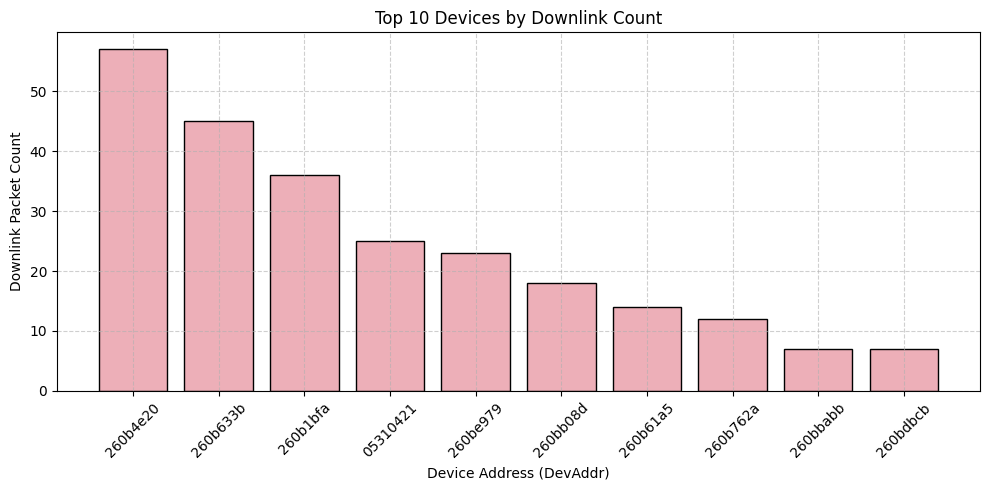

In [19]:
import matplotlib.pyplot as plt

# 1️⃣ Count downlink packets per device
device_downlink_counts = df['DevAddr'].value_counts().reset_index()
device_downlink_counts.columns = ['DevAddr', 'downlink_count']

# 2️⃣ Top 10 devices
top_10_downlink_devices = device_downlink_counts.head(10)

print("Top 10 devices by downlink count:")
print(top_10_downlink_devices)

# 3️⃣ Plot
plt.figure(figsize=(10, 5))
plt.bar(top_10_downlink_devices['DevAddr'].astype(str), top_10_downlink_devices['downlink_count'], color='#edafb8', edgecolor='black')
plt.title('Top 10 Devices by Downlink Count')
plt.xlabel('Device Address (DevAddr)')
plt.ylabel('Downlink Packet Count')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


🔎 Insights
🔹 Devices like 260b4e20 and 260b633b are likely the most heavily managed or critical devices (e.g., gateways, control nodes).
🔹 The gap to the rest indicates fewer devices need frequent downlink commands — typical for many IoT deployments where only some nodes get frequent updates.
🔹 This also suggests possible tiered device roles:

Top talkers → important sensors or control nodes.

Lower activity → standard sensors or end devices.

#### Identify One-Time Downlink Devices

In [20]:
# Identify devices with only one downlink
one_time_downlink_devices = device_downlink_counts[device_downlink_counts['downlink_count'] == 1]

print(f"Number of devices that received only one downlink: {len(one_time_downlink_devices)}")
print(one_time_downlink_devices)

Number of devices that received only one downlink: 170
      DevAddr  downlink_count
38   cf13d0b8               1
39   044e12a0               1
40   2d103948               1
41   869ff24f               1
42   3f97dfed               1
..        ...             ...
203  c0ba3c8e               1
204  899d75e8               1
205  3edd98cb               1
206  d81bf1bc               1
207  27001914               1

[170 rows x 2 columns]


🔹 These 170 devices are probably low-maintenance devices (like sensors that don’t need dynamic reconfiguration).
🔹 The remaining devices (with more than 1 downlink) are likely the ones that require ongoing control or monitoring.

### Hourly Downlink Traffic

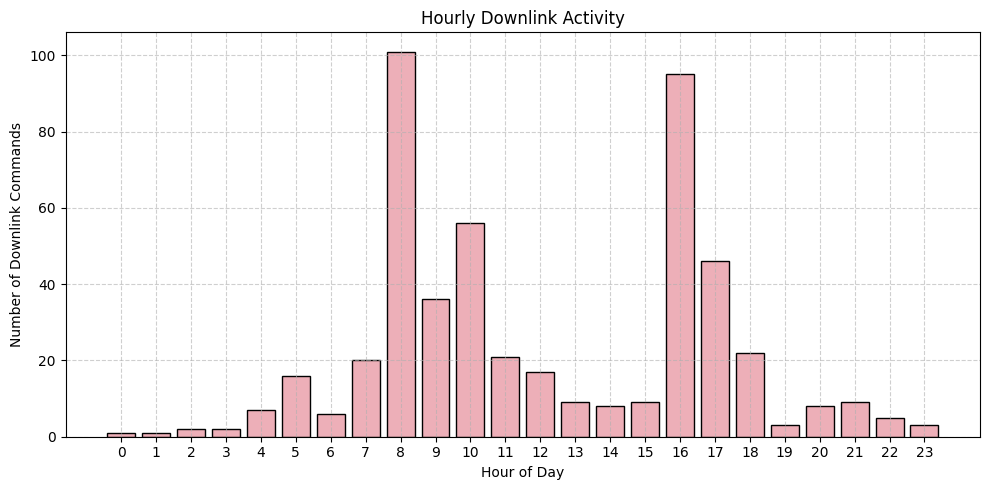

In [21]:
import matplotlib.pyplot as plt

# Convert timestamps to datetime (if not done already)
df['datetime'] = pd.to_datetime(df['tmst'], unit='s')  # or 'ms' if your timestamps are in milliseconds

# Extract the hour of the day
df['hour'] = df['datetime'].dt.hour

# Count number of downlink commands per hour
hourly_downlink_counts = df['hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(hourly_downlink_counts.index, hourly_downlink_counts.values, color='#edafb8', edgecolor='black')
plt.title('Hourly Downlink Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Downlink Commands')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


✅ Two major spikes in downlink activity:

Around 8–9 AM

Around 3–4 PM

✅ Lulls during nighttime (midnight to early morning).
✅ Activity ramps up after 4 AM and peaks in two waves — probably aligned with network maintenance windows or device activity schedules.

#### Daily Downlink Activity

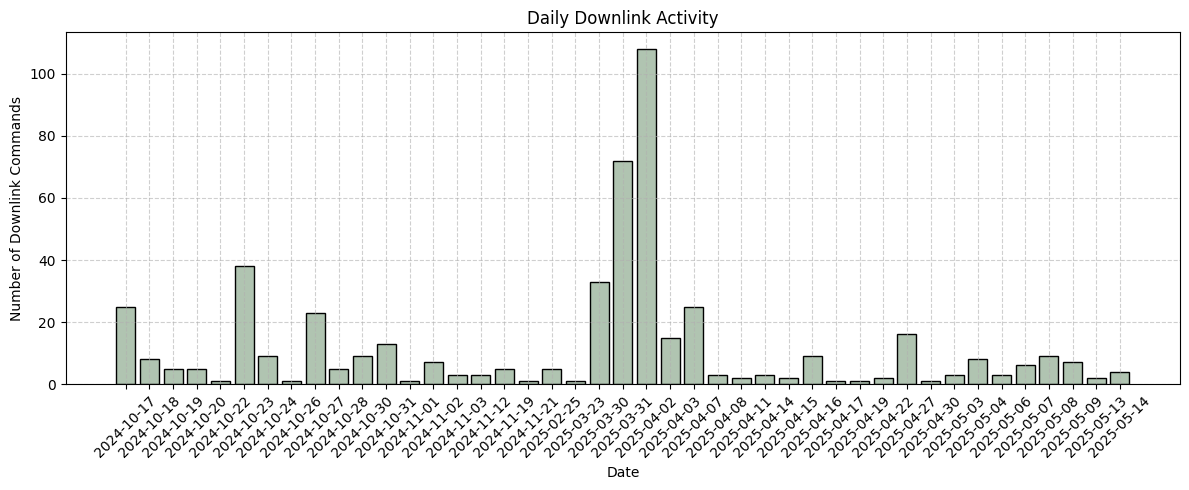

In [22]:
import matplotlib.pyplot as plt

# Extract date from timestamp
df['date'] = df['datetime'].dt.date

# Count downlink commands per day
daily_downlink_counts = df['date'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 5))
plt.bar(daily_downlink_counts.index.astype(str), daily_downlink_counts.values, color='#b0c4b1', edgecolor='black')
plt.title('Daily Downlink Activity')
plt.xlabel('Date')
plt.ylabel('Number of Downlink Commands')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


📊 Key Observations
- ✅ One major spike on 2025-03-01 — a day with significantly more downlink commands than others (above 100).
- ✅ Outside of that spike, daily activity is mostly low and scattered, with most days seeing fewer than 20 downlink commands.
- ✅ Overall low-frequency downlink usage except for this one burst of activity.

####  Device Lifespan in Downlink

    DevAddr                 min                 max  lifespan_hours  \
0  0397df91 2025-03-30 17:09:14 2025-03-30 17:09:14        0.000000   
1  03e4cd3d 2024-10-19 14:18:30 2024-10-19 14:18:30        0.000000   
2  044e12a0 2025-04-02 18:00:38 2025-04-02 18:00:38        0.000000   
3  05310421 2024-10-24 13:29:04 2024-10-27 17:23:42       75.910556   
4  0669b635 2025-04-27 09:16:29 2025-04-27 09:16:29        0.000000   

   lifespan_days  
0        0.00000  
1        0.00000  
2        0.00000  
3        3.16294  
4        0.00000  


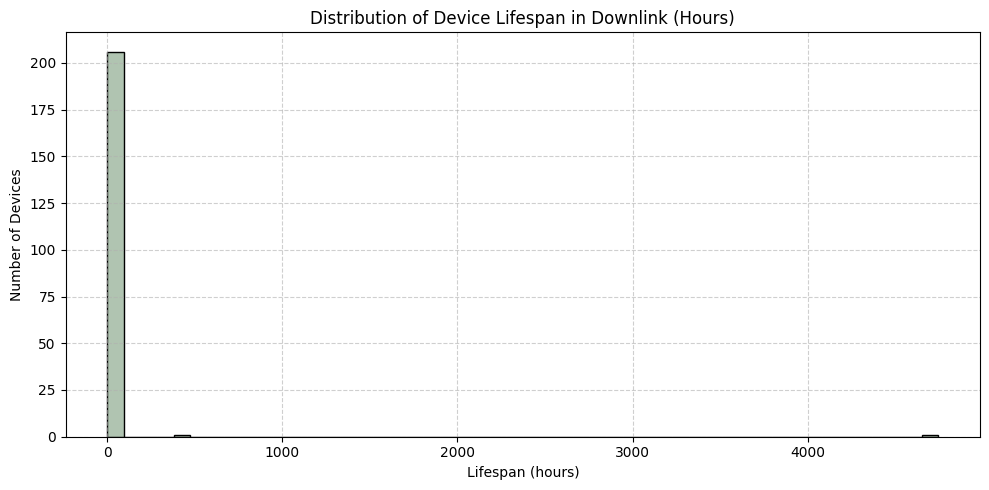

In [23]:
# Group by device and get first/last seen downlink
downlink_lifespan = df.groupby('DevAddr')['datetime'].agg(['min', 'max']).reset_index()

# Calculate lifespan (in hours and days)
downlink_lifespan['lifespan_hours'] = (downlink_lifespan['max'] - downlink_lifespan['min']).dt.total_seconds() / 3600
downlink_lifespan['lifespan_days'] = downlink_lifespan['lifespan_hours'] / 24

# Show top rows
print(downlink_lifespan.head())

# Plot histogram of lifespan (in hours)
plt.figure(figsize=(10, 5))
plt.hist(downlink_lifespan['lifespan_hours'], bins=50, color='#b0c4b1', edgecolor='black')
plt.title('Distribution of Device Lifespan in Downlink (Hours)')
plt.xlabel('Lifespan (hours)')
plt.ylabel('Number of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- ✅ The overwhelming majority of devices have zero or near-zero lifespan — they received a downlink only once or within a very short window.
- ✅ A very small group of outlier devices has longer lifespans (1000+ hours / 40+ days).

### FPort Usage by Device

#### FPort Category Usage by Device

FPort_category  Control_pct  Application_pct
DevAddr                                     
0397df91                0.0            100.0
03e4cd3d                0.0              0.0
044e12a0                0.0            100.0
05310421              100.0              0.0
0669b635                0.0            100.0


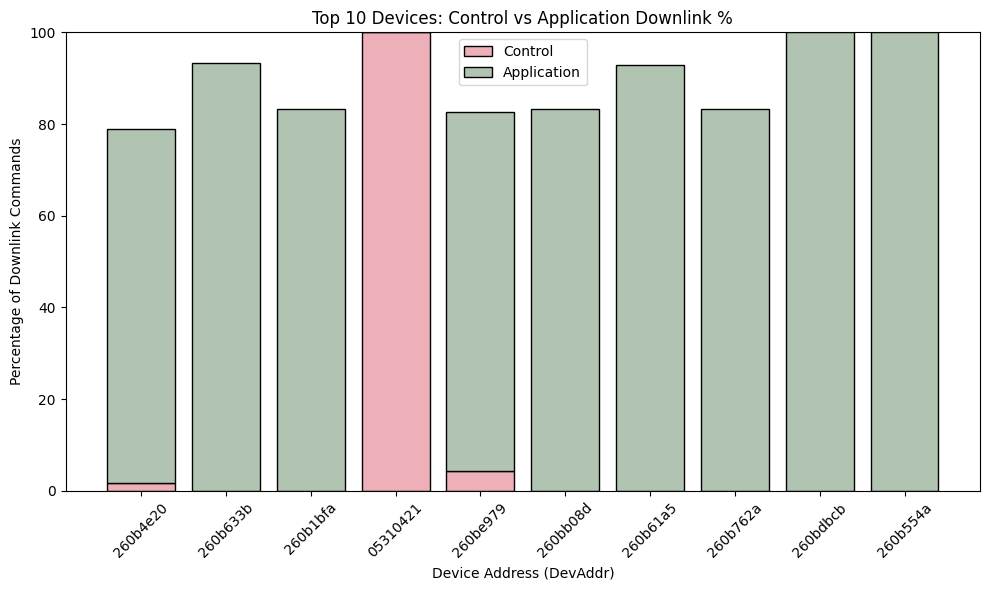

In [24]:
# Function to categorize FPort
def fport_category(fport):
    if fport == 0:
        return 'Control'
    elif 1 <= fport <= 223:
        return 'Application'
    elif 224 <= fport <= 255:
        return 'Reserved'
    else:
        return 'Unknown'

# Categorize FPort usage
df['FPort_category'] = df['FPort'].apply(fport_category)

# Count per device
fport_usage_by_device = df.groupby(['DevAddr', 'FPort_category']).size().unstack(fill_value=0)

# Calculate percentage usage
fport_usage_by_device['Total'] = fport_usage_by_device.sum(axis=1)
fport_usage_by_device['Control_pct'] = fport_usage_by_device.get('Control', 0) / fport_usage_by_device['Total'] * 100
fport_usage_by_device['Application_pct'] = fport_usage_by_device.get('Application', 0) / fport_usage_by_device['Total'] * 100

# Show top rows
print(fport_usage_by_device[['Control_pct', 'Application_pct']].head())

# Optional: Plot a few example devices as stacked bar chart
top_devices = fport_usage_by_device.sort_values(by='Total', ascending=False).head(10)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(top_devices.index.astype(str), top_devices['Control_pct'], label='Control', color='#edafb8', edgecolor='black')
plt.bar(top_devices.index.astype(str), top_devices['Application_pct'], bottom=top_devices['Control_pct'], label='Application', color='#b0c4b1', edgecolor='black')
plt.title('Top 10 Devices: Control vs Application Downlink %')
plt.xlabel('Device Address (DevAddr)')
plt.ylabel('Percentage of Downlink Commands')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

- ✅ Most of the top 10 devices receive almost exclusively application data (green bars).
- ✅ Only one device (05310421) has 100% control messages (red bar) — suggesting it’s a device primarily used for configuration or management.
- ✅ Another device (260b4e20) has ~5% control commands — indicating occasional reconfiguration or periodic control.

#### Identify Outlier Devices

In [25]:
# Threshold for considering a device as control-heavy
control_threshold = 50  # e.g., more than 50% control messages

# Identify control-heavy devices
control_heavy_devices = fport_usage_by_device[fport_usage_by_device['Control_pct'] > control_threshold]

print(f"Number of control-heavy devices (> {control_threshold}% control): {len(control_heavy_devices)}")
print(control_heavy_devices[['Control_pct', 'Application_pct']])

Number of control-heavy devices (> 50% control): 5
FPort_category  Control_pct  Application_pct
DevAddr                                     
05310421              100.0              0.0
267d1185              100.0              0.0
4a24a17e              100.0              0.0
4f7cef80              100.0              0.0
68ac0adb              100.0              0.0


- ✅ 5 devices have 100% control messages (no application data at all).
- ✅ These are likely pure control endpoints (no data collection role, only receive network commands).

### Downlink Command “Lifespan” (Temporal Spread)

Analyze how each device’s downlink activity is spread over time — not just start and end times, but also how frequently downlinks occur for that device.

#### Time Gaps Between Downlink Commands

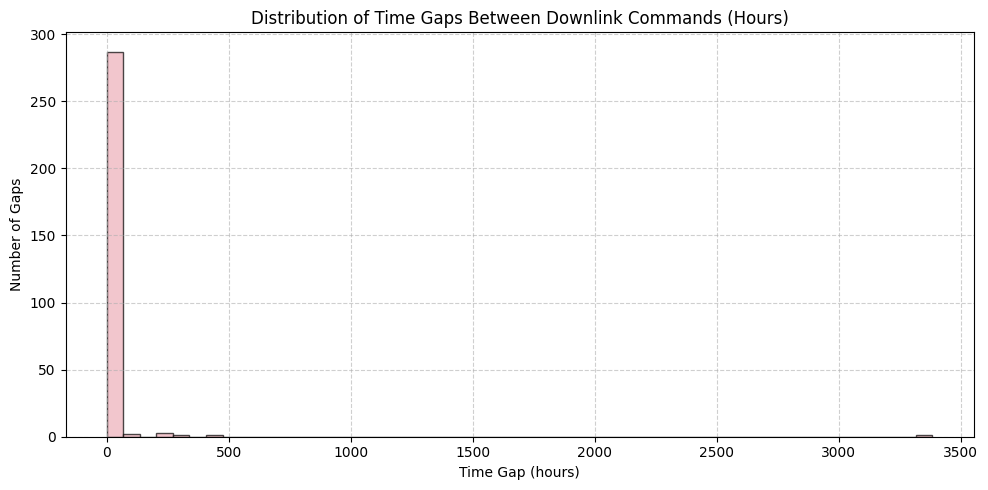

In [26]:
# For each device, calculate time differences (in hours) between consecutive downlinks
downlink_gaps = []

for dev, group in df.groupby('DevAddr'):
    group_sorted = group.sort_values(by='datetime')
    time_diffs = group_sorted['datetime'].diff().dropna().dt.total_seconds() / 3600  # gap in hours
    downlink_gaps.extend(time_diffs)

# Plot distribution of these time gaps
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(downlink_gaps, bins=50, color='#edafb8', edgecolor='black', alpha=0.7)
plt.title('Distribution of Time Gaps Between Downlink Commands (Hours)')
plt.xlabel('Time Gap (hours)')
plt.ylabel('Number of Gaps')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
